In [1]:
!pip install -r ..//requirements.txt;
!pip install openai;
!pip install psycopg2-binary;
!pip install -U sentence-transformers
import sys
import sys;
import os;
from pathlib import Path
import pandas as pd
import numpy as np
import requests
import PIL
from IPython.display import display
from io import BytesIO
import ast
import io
from PIL import Image
import torchvision.transforms as transforms
import torch


# Get the path to /notebooks/pricesto
project_root = Path('/notebooks')

# Add this path to sys.path if it's not already there
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    
from fastapiapp.app.environment import load_environment
load_environment('staging');

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 7.6 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 801.1 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 795.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.9 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: typing-extensions
    Found existing installat

In [3]:
# this runs to set up 2 dirs, processed data and raw data, 
# a .csv comes into raw_data is processed and then sent to processed_data

# Get the current working directory
current_working_directory = os.getcwd()

# Append "/data" to the CWD
processed_data_directory_path = os.path.join(current_working_directory, "processed_data")
raw_directory_path = os.path.join(current_working_directory, "raw_data")

# Use os.makedirs to create the directory
os.makedirs(processed_data_directory_path, exist_ok=True)
os.makedirs(raw_directory_path, exist_ok=True)

print(f"Data directory created at: {raw_directory_path}")
print(f"Data directory created at: {processed_data_directory_path}")

Data directory created at: /notebooks/fastapiapp/machine_learning/raw_data
Data directory created at: /notebooks/fastapiapp/machine_learning/processed_data


In [3]:
# download  scraped_list.csv
from fastapiapp.app.aws.s3 import s3

# download latest file in s3://pricesto/staging/scraped_data/ and save

# file to save raw_data in
local_dir = '/notebooks/fastapiapp/machine_learning/raw_data'


# get the most recent .csv from the scraped_data folder on aws
def download_lastest_scrapped_data(s3, local_dir):
    bucket_name = 'pricesto'
    prefix = 'staging/scraped_data/'
    objects = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

    if 'Contents' in objects:
        # Exclude folder placeholders and sort by last modified date
        sorted_objects = sorted(
            [obj for obj in objects['Contents'] if not obj['Key'].endswith('/')],
            key=lambda obj: obj['LastModified'],
            reverse=True
        )

        if sorted_objects:
            # Getting the key of the latest object
            latest_object_key = sorted_objects[0]['Key']

            # Downloading the latest object
            local_file_path = os.path.join(local_dir, latest_object_key.split('/')[-1])
            s3.download_file(bucket_name, latest_object_key, local_file_path)

            return local_file_path
        else:
            return "No valid objects to download in the bucket."

    else:
        return "No objects in the bucket."

# latest_file_path is used as a handle to get the file
latest_file_path = download_lastest_scrapped_data(s3, local_dir)


aquired s3 client <botocore.client.S3 object at 0x7f03e9af47c0>


In [32]:
# turn latest file into df
df = pd.read_csv(latest_file_path)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49175 entries, 0 to 49174
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   49175 non-null  int64  
 1   hash                 49175 non-null  int64  
 2   title                49175 non-null  object 
 3   price                45765 non-null  object 
 4   odometer             48971 non-null  float64
 5   transmission         48820 non-null  object 
 6   listing_description  49175 non-null  object 
 7   posting_body         49175 non-null  object 
 8   embedding            0 non-null      float64
 9   image_links          49175 non-null  object 
 10  cylinders            34629 non-null  object 
 11  drive                36285 non-null  object 
 12  fuel                 49064 non-null  object 
 13  url                  49175 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 5.3+ MB


In [33]:
# clean up all text 

def remove_new_lines(str):
    return str.replace('\n','')

def remove_qr(str):
    qr_str ='QR Code Link to This Post'
    return str.replace(qr_str,'')

# test= df.posting_body[11111]
# print(test[:124])
# print(remove_new_lines(remove_qr(test))[:124])

In [34]:
df['posting_body']=df['posting_body'].apply(remove_qr).apply(remove_new_lines)

In [35]:
print(df.title[22])
print(df.listing_description[22])
print(df.posting_body[22])

2004 Nissan Armada BIG ENOUGH FOR EVERYTHING!!!- Best Finance Deals!
2004 Nissan Armada
🚩 2004 *Nissan* *Armada* *SE 2WD* *SPORT UTILITY 4-DR*.🚩 ☎ Call or TEXT (520) 839-0316 For Vehicle Details!🚨 BAD CREDIT❓   NO CREDIT❓   FIRST TIME BUYER❓   BANKRUPTCY❓   NO PROBLEM👍 ✅ Get Financed Now!  Get Pre Approved for $111 Low Monthly Payment!↳ Apply at the link below:👇 http://hm.post2cl.com/financing.php🔆 Vehicle Comments:🔆 BRIGHT WHITE LOOKIN RIGHT!!! COME GET ME TODAY!! Why add another expensive bill to your life when you can come down to Heritage Motors and get this vehicle for next to nothing, and have a solid running transportation? the faster you get here the faster you will be driving!!! Heritage Motors is family owned and operated! We are a BUY HERE PAY HERE and have been in business for over 20 years!! Heritage Motors is now reporting credit through Equifax!! Come grow your credit with us!! Largest inventory is Central ARIZONA and Tri-Valley Area!! Heritage Motors is located in Arizo

In [43]:
# remove all listings with out a price 
# NOTE: this could mean that there is a price in the body, but I am not going to extract that
df_cleaned = df.dropna(subset=['price'])

In [46]:
# for all NAN nvalues of the the columns title, odometer, transmission, cyllinders, drive, fuel
# set the value as None
columns_to_update = ['title', 'odometer', 'transmission', 'cylinders', 'drive', 'fuel']

# Replace NaN with None in the specified columns
df_cleaned[columns_to_update] = df_cleaned[columns_to_update].fillna(value='unknown')

/tmp/ipykernel_33/1808864726.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[columns_to_update] = df_cleaned[columns_to_update].fillna(value='unknown')


In [55]:
df_cleaned.head(5)


,id,hash,title,price,odometer,transmission,listing_description,posting_body,embedding,image_links,cylinders,drive,fuel,url
0,6363,4364090514584345668,2016 MINI Cooper Hardtop 4 Door 4dr HB,14995.00,86000.0,automatic,2016 Mini Cooper Hardtop 4 Door,2016 *** Mini Cooper Hardtop 4 Door 4dr HB Sed...,NaN,"[""https://images.craigslist.org/00w0w_j8bOqhSj...",3 cylinders,fwd,gas,https://tucson.craigslist.org/ctd/d/tucson-201...
1,6364,741590300646685614,2012 Subaru Outback 4dr Wgn H4 Auto 2.5i Premium,9995.00,185000.0,automatic,2012 Subaru Outback,2012 *** Subaru Outback 4dr Wgn H4 Auto 2.5i P...,NaN,"[""https://images.craigslist.org/00x0x_dYvp7KVw...",4 cylinders,4wd,gas,https://tucson.craigslist.org/ctd/d/tucson-201...
2,6365,-8401213550643018466,2006 Subaru B9 Tribeca 7-Pass Gray Int,"6,995",165000.0,automatic,2006 Subaru B9 Tribeca,2006 *** Subaru B9 Tribeca 7-Pass Gray Int SUV...,NaN,"[""https://images.craigslist.org/00z0z_4CEyZyk1...",6 cylinders,4wd,gas,https://tucson.craigslist.org/ctd/d/tucson-200...
3,6366,-7918394552553228318,2015 Chevrolet Tahoe 2WDLTZ 2 WDLTZ 2-WDLTZ Tv...,"25,950",108666.0,automatic,2015 Chevrolet Tahoe 2WDLTZ Tv Navi,2015 Chevrolet Tahoe 2WDLTZ 2 WDLTZ 2-WDLTZ Tv...,NaN,"[""https://images.craigslist.org/00D0D_lgexCzZU...",8 cylinders,unknown,gas,https://tucson.craigslist.org/ctd/d/phoenix-20...
4,6648,1498440714900410147,2006 Jeep Rubicon,"17,500",86000.0,manual,2006 jeep wrangler,"2006 Jeep Rubicon. 86,000 miles. New tires in...",NaN,"[""https://images.craigslist.org/00L0L_hwrjS6cV...",6 cylinders,4wd,gas,https://yuma.craigslist.org/cto/d/tacna-2006-j...


In [55]:
from sentence_transformers import SentenceTransformer
emb_model = SentenceTransformer('all-mpnet-base-v2')

#Our sentences we like to encode
sentences = ['ford truck good condition']

#Sentences are encoded by calling model.encode()
import time
start = time.time()
embeddings = emb_model.encode(sentences)
end = time.time()
print(end-start)

results = list(zip(sentences, embeddings))
results[0][1]
               

0.09082317352294922


array([-3.94645482e-02,  4.82151397e-02, -2.06748699e-03,  5.77888414e-02,
       -5.86715061e-04, -5.07388636e-03, -2.68100332e-02,  8.39162543e-02,
       -3.40918675e-02, -7.21063763e-02, -4.05340977e-02,  7.34066032e-03,
        4.51389626e-02,  1.12908916e-03,  1.59330033e-02, -1.00283499e-03,
       -3.45336311e-02,  3.27685615e-04, -1.34907290e-02, -6.89267218e-02,
       -8.17491964e-04, -3.32861021e-02, -1.23196784e-02, -2.09516659e-02,
       -3.03367674e-02,  1.72549800e-04, -1.23420395e-02, -3.78443450e-02,
       -3.28760706e-02,  7.54681241e-04, -3.87686826e-02,  6.21383116e-02,
        8.34748987e-03,  4.70199138e-02,  1.65474057e-06, -1.97188854e-02,
       -8.79947189e-03, -1.18697844e-02,  3.15305628e-02,  6.57282099e-02,
        8.33386183e-03,  2.64955778e-02, -3.36508416e-02, -7.93600734e-03,
       -6.41026944e-02, -6.48581088e-02, -2.15528756e-02,  5.51553890e-02,
        3.26062478e-02, -1.26991617e-02,  5.26016112e-03,  3.33109964e-03,
        3.10080650e-04,  

In [11]:
emb_model.max_seq_length

384

In [103]:
file = latest_file_path.split('/')[-1]
df_cleaned.to_csv(f'/notebooks/fastapiapp/machine_learning/processed_data/{file}')

In [22]:
# load df
df_cleaned = pd.read_csv('/notebooks/fastapiapp/machine_learning/processed_data/scrapped_listing_202312021223.csv')

In [9]:
df_cleaned['embedding'] = df_cleaned['embedding'].astype(object)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45765 entries, 0 to 45764
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           45765 non-null  int64 
 1   id                   45765 non-null  int64 
 2   hash                 45765 non-null  int64 
 3   title                45765 non-null  object
 4   price                45765 non-null  object
 5   odometer             45765 non-null  object
 6   transmission         45765 non-null  object
 7   listing_description  45765 non-null  object
 8   posting_body         45764 non-null  object
 9   embedding            0 non-null      object
 10  image_links          45765 non-null  object
 11  cylinders            45765 non-null  object
 12  drive                45765 non-null  object
 13  fuel                 45765 non-null  object
 14  url                  45765 non-null  object
dtypes: int64(3), object(12)
memory usage: 5.2+ MB


In [29]:
def prepare_text(row):
    title = row['title']
    posting_body = row['posting_body']
    try:
        posting_truncated = ' '.join(posting_body.split(' ')[:200])
    except:
        posting_truncated = posting_body
    text = f"title: {title} posting: {posting_truncated}"
    return text


def embed_posting_body(batch):
    texts = []
    for _, row in batch.iterrows():
        texts.append(prepare_text(row))
    return emb_model.encode(texts)  # Assuming emb_model is your embedding model


 
batch_size = 150
for start in range(0, len(df_cleaned), batch_size):
    end = min(start + batch_size, len(df_cleaned))
    batch = df_cleaned.iloc[start:end]
    embeddings = embed_posting_body(batch)

    # Check if the number of embeddings matches the number of rows in the batch
    if len(embeddings) == len(batch):
        for i, embedding in enumerate(embeddings):
            df_cleaned.at[start + i, 'embedding'] = str(embedding.tolist())
    else:
        raise ValueError("The number of embeddings does not match the number of rows in the batch.")
        
    # print update
    print(f'running batch {start}')



running batch 0
running batch 150
running batch 300
running batch 450
running batch 600
running batch 750
running batch 900
running batch 1050
running batch 1200
running batch 1350
running batch 1500
running batch 1650
running batch 1800
running batch 1950
running batch 2100
running batch 2250
running batch 2400
running batch 2550
running batch 2700
running batch 2850
running batch 3000
running batch 3150
running batch 3300
running batch 3450
running batch 3600
running batch 3750
running batch 3900
running batch 4050
running batch 4200
running batch 4350
running batch 4500
running batch 4650
running batch 4800
running batch 4950
running batch 5100
running batch 5250
running batch 5400
running batch 5550
running batch 5700
running batch 5850
running batch 6000
running batch 6150
running batch 6300
running batch 6450
running batch 6600
running batch 6750
running batch 6900
running batch 7050
running batch 7200
running batch 7350
running batch 7500
running batch 7650
running batch 7800
ru

In [29]:
df_cleaned.to_csv(f'/notebooks/fastapiapp/machine_learning/processed_data/scrapped_listing_202312021223.csv', index=False)

KeyboardInterrupt: 

In [52]:
df_cleaned.head()

,id,hash,title,price,odometer,transmission,listing_description,posting_body,embedding,image_links,cylinders,drive,fuel,url
0,6363,4364090514584345668,2016 MINI Cooper Hardtop 4 Door 4dr HB,14995.00,86000.0,automatic,2016 Mini Cooper Hardtop 4 Door,2016 *** Mini Cooper Hardtop 4 Door 4dr HB Sed...,"[-0.026629021391272545, 0.009234974160790443, ...","[""https://images.craigslist.org/00w0w_j8bOqhSj...",3 cylinders,fwd,gas,https://tucson.craigslist.org/ctd/d/tucson-201...
1,6364,741590300646685614,2012 Subaru Outback 4dr Wgn H4 Auto 2.5i Premium,9995.00,185000.0,automatic,2012 Subaru Outback,2012 *** Subaru Outback 4dr Wgn H4 Auto 2.5i P...,"[-0.04993885010480881, 0.041270047426223755, 0...","[""https://images.craigslist.org/00x0x_dYvp7KVw...",4 cylinders,4wd,gas,https://tucson.craigslist.org/ctd/d/tucson-201...
2,6365,-8401213550643018466,2006 Subaru B9 Tribeca 7-Pass Gray Int,"6,995",165000.0,automatic,2006 Subaru B9 Tribeca,2006 *** Subaru B9 Tribeca 7-Pass Gray Int SUV...,"[-0.03522860258817673, 0.040162671357393265, -...","[""https://images.craigslist.org/00z0z_4CEyZyk1...",6 cylinders,4wd,gas,https://tucson.craigslist.org/ctd/d/tucson-200...
3,6366,-7918394552553228318,2015 Chevrolet Tahoe 2WDLTZ 2 WDLTZ 2-WDLTZ Tv...,"25,950",108666.0,automatic,2015 Chevrolet Tahoe 2WDLTZ Tv Navi,2015 Chevrolet Tahoe 2WDLTZ 2 WDLTZ 2-WDLTZ Tv...,"[-0.043356165289878845, -0.035089604556560516,...","[""https://images.craigslist.org/00D0D_lgexCzZU...",8 cylinders,unknown,gas,https://tucson.craigslist.org/ctd/d/phoenix-20...
4,6648,1498440714900410147,2006 Jeep Rubicon,"17,500",86000.0,manual,2006 jeep wrangler,"2006 Jeep Rubicon. 86,000 miles. New tires in...","[-0.008691417053341866, 0.017557503655552864, ...","[""https://images.craigslist.org/00L0L_hwrjS6cV...",6 cylinders,4wd,gas,https://yuma.craigslist.org/cto/d/tacna-2006-j...


In [56]:
from fastapiapp.app.aws.s3 import s3


aquired s3 client <botocore.client.S3 object at 0x7fd682425430>


In [ ]:
#
# Create a new DataFrame with one-hot encoded columns
one_hot_encoded_df = pd.get_dummies(df_cleaned[one_hot_categories])
# combine onto df_cleaned and save
df_cleaned = pd.concat([df_cleaned, one_hot_encoded_df], axis=1)
df_cleaned.info()


NameError: name 'one_hot_categories' is not defined

In [17]:
df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41257 entries, 0 to 41256
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      41257 non-null  int64 
 1   hash                    41257 non-null  int64 
 2   title                   41257 non-null  object
 3   price                   41257 non-null  object
 4   odometer                41257 non-null  object
 5   transmission            41257 non-null  object
 6   listing_description     41257 non-null  object
 7   posting_body            41257 non-null  object
 8   embedding               41257 non-null  object
 9   image_links             41257 non-null  object
 10  cylinders               41257 non-null  object
 11  drive                   41257 non-null  object
 12  fuel                    41257 non-null  object
 13  url                     41257 non-null  object
 14  transmission_automatic  41257 non-null  int64 
 15  tr

In [18]:
df_cleaned.to_csv(f'/notebooks/fastapiapp/machine_learning/processed_data/scrapped_listing_202312021223.csv', index=False)

In [14]:

# build full feature vector
def build_non_image_feature_vector(row):
    """
    features:
        odometer: normalized between 0 and 200,000, if not provided value is -1
        embedding: 768 dimension vector from the title and first 200 words of body
        transmission: one shot encoded 4 options, other is from cL, unknow means blank
        cylinders: one shot encoded 9 options, other is from cl. unknown means blank
        drive: one shot encoded 4 options, unknown means blank
        fuel: one shot encoded 6 options, other is from cl, unknown means blank
    """
    ODOMETER_NORMALIZED = 200000
    COLS = row.index.tolist()
    FEATURES = ['transmission', 'cylinders','drive','fuel']
    odometer = 1
    transmission = 4
    embedding = 768
    cylinders = 9
    drive = 4
    fuel = 6
    length = odometer+transmission+embedding+cylinders+drive+fuel
    f_vec = np.zeros(length)
    
    vectors = {}
    try:
        # when odometer not provided value is -1
        odometer_value = min( float(row['odometer']) / 200000.0, 1)
    except:
        odometer_value = -1
    vectors['odometer'] = np.array([odometer_value])
    vectors['embedding'] = np.array(ast.literal_eval(row['embedding']))
    
    for feature in FEATURES:
        feature_vec = []
        for col in COLS:
            if feature == col:
                continue
            if feature in col:
                feature_vec.append(row[col])
        vectors[feature] = np.array(feature_vec)

    f_vec= np.concatenate((
        vectors['odometer'], 
        vectors['embedding'],
        vectors['transmission'],
        vectors['cylinders'],
        vectors['drive'],
        vectors['fuel'],
    ))
    
    return f_vec.tolist()
# vec =build_non_image_feature_vector(df_cleaned.iloc[0])
# print(vec)
    

In [15]:
df_cleaned['full_feature_embedding'] = df_cleaned.apply(build_non_image_feature_vector, axis=1)


In [4]:
#
# This is where we start working with the CNN side of things. We need an approach for
# combineing multiple images into a single output


In [5]:
df_cleaned = pd.read_csv('/notebooks/fastapiapp/machine_learning/processed_data/scrapped_listing_202312021223.csv')

In [134]:
type(df_cleaned.loc[0].full_feature_embedding)

str

In [35]:
from fastapiapp.app.aws.s3 import s3


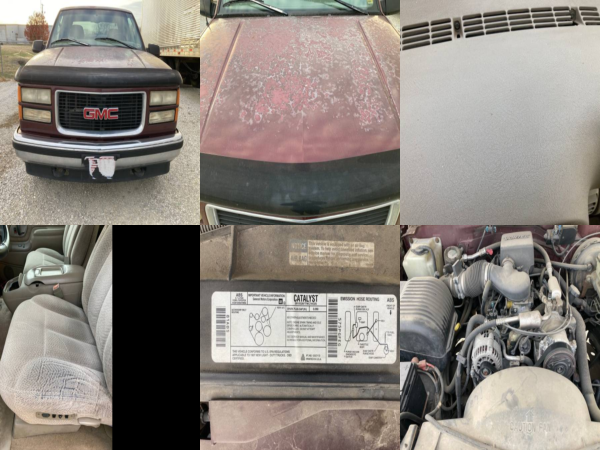

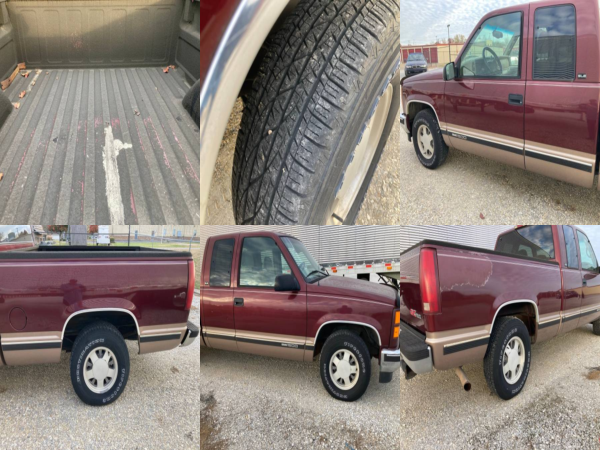

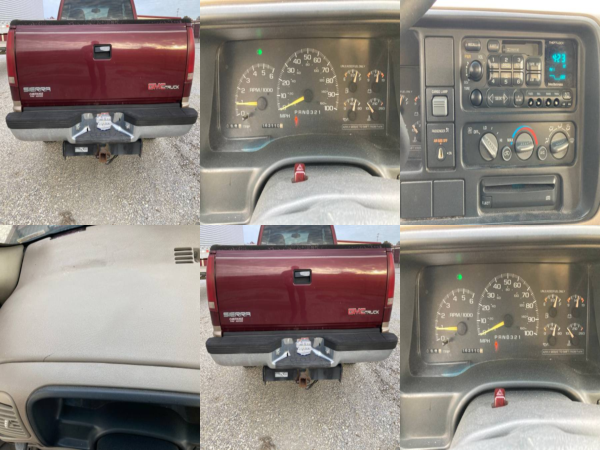

torch.Size([3, 450, 600])


In [105]:
#requires s3 object in global
def create_image_mosaics(df_row, show=False):
    def get_image_listing(s3, hash):
        prefix = f'staging/images/{hash}/'
        objects = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
        return objects.get('Contents', [])
    
    def download_image(s3, key):
        image_buffer = io.BytesIO()
        s3.download_fileobj(Bucket=bucket_name, Key=key, Fileobj=image_buffer)
        return image_buffer
    
    def process_single_image(image_buffer):
        # Load the image from buffer
        image = Image.open(image_buffer)

        # Define the transforms
        transform = transforms.Compose([
            # Pad the image to make it 600x450 if smaller
            transforms.Pad((0, 0, max(0, 600 - image.size[0]), max(0, 450 - image.size[1])), fill=0),
            # Resize to 225x200
            transforms.Resize((225, 200)),
            # Convert image to tensor
            transforms.ToTensor()
        ])

        # Apply the transforms
        return transform(image)

    def combine_images(image_tensors):
        # Ensure there are exactly 6 images
        while len(image_tensors) < 6:
            image_tensors += image_tensors[:6 - len(image_tensors)]

        # Combine images into one tensor
        upper_row = torch.cat(image_tensors[:3], dim=2)
        lower_row = torch.cat(image_tensors[3:], dim=2)
        combined_image = torch.cat((upper_row, lower_row), dim=1)

        return combined_image

    # Get the list of image keys from the DataFrame row
    total_images = len(df_row.image_links)
    listing_hash = df_row.hash
    images_list = get_image_listing(s3, listing_hash)

    # Download and process images
    processed_imgs = []
    for i in range(total_images):
        image_key = images_list[i]['Key']
        image_buffer = download_image(s3, image_key)
        processed_img = process_single_image(image_buffer)
        processed_imgs.append(processed_img)

    # Create mosaics
    num_mosaics = len(processed_imgs) // 6 + (1 if len(processed_imgs) % 6 else 0)
    mosaics = []
    for i in range(num_mosaics):
        mosaic = combine_images(processed_imgs[i*6:(i+1)*6])
        mosaics.append(mosaic)
        if show:
            show_tensor_image(mosaic)

    return mosaics

# Example usage
#df_row = df_cleaned.iloc[35000]
#mosaics = create_image_mosaics(df_row, show=True)
#print((mosaics[0].shape))

In [87]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

In [127]:
class CarListingDataset(Dataset):
    def __init__(self, dataframe, show_images=False):
        """
        dataframe: A Pandas DataFrame containing the data.
        """
        self.dataframe = dataframe
        self.show_images = show_images


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the data for one listing
        listing = self.dataframe.iloc[idx]
        # Download and process the image
        full_tensor = listing['full_feature_embedding']
        mosaics = self.create_image_mosaics(listing,show=self.show_images)
        price = listing['price']
        
        return mosaics, full_tensor, price

    @staticmethod
    def create_image_mosaics(df_row, show=False):
        def get_image_listing(s3, hash):
            prefix = f'staging/images/{hash}/'
            objects = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
            return objects.get('Contents', [])

        def download_image(s3, key):
            image_buffer = io.BytesIO()
            s3.download_fileobj(Bucket=bucket_name, Key=key, Fileobj=image_buffer)
            return image_buffer

        def process_single_image(image_buffer):
            # Load the image from buffer
            image = Image.open(image_buffer)

            # Define the transforms
            transform = transforms.Compose([
                # Pad the image to make it 600x450 if smaller
                transforms.Pad((0, 0, max(0, 600 - image.size[0]), max(0, 450 - image.size[1])), fill=0),
                # Resize to 225x200
                transforms.Resize((225, 200)),
                # Convert image to tensor
                transforms.ToTensor()
            ])

            # Apply the transforms
            return transform(image)

        def combine_images(image_tensors):
            # Ensure there are exactly 6 images
            while len(image_tensors) < 6:
                image_tensors += image_tensors[:6 - len(image_tensors)]

            # Combine images into one tensor
            upper_row = torch.cat(image_tensors[:3], dim=2)
            lower_row = torch.cat(image_tensors[3:], dim=2)
            combined_image = torch.cat((upper_row, lower_row), dim=1)

            return combined_image

        # Get the list of image keys from the DataFrame row
        total_images = len(df_row['image_links'])
        listing_hash = df_row.hash
        images_list = get_image_listing(s3, listing_hash)

        # Download and process images
        processed_imgs = []
        for i in range(total_images):
            image_key = images_list[i]['Key']
            image_buffer = download_image(s3, image_key)
            processed_img = process_single_image(image_buffer)
            processed_imgs.append(processed_img)

        # Create mosaics
        num_mosaics = len(processed_imgs) // 6 + (1 if len(processed_imgs) % 6 else 0)
        mosaics = []
        for i in range(num_mosaics):
            mosaic = combine_images(processed_imgs[i*6:(i+1)*6])
            mosaics.append(mosaic)
            if show:
                show_tensor_image(mosaic)
                
        return mosaics

# testing code
dataset = CarListingDataset(df_cleaned, show_images=False)
moasic, full_vec, price = next(iter(DataLoader(dataset, batch_size=1, shuffle=True)))


In [132]:
full_vec[0]


'[0.865, 0.0038504533004015684, 0.035040006041526794, -0.0011254692217335105, 0.06482138484716415, -0.015623909421265125, -0.026543740183115005, 0.004667949862778187, 0.04510752484202385, 0.02514720894396305, 0.0019296782556921244, -0.03270982205867767, 0.044561516493558884, 0.06348711997270584, 0.09791834652423859, -0.027337918058037758, -0.04862116277217865, 0.008441279642283916, 0.012264532037079334, 0.05168728157877922, -0.03571819141507149, -0.02881862036883831, 0.021242540329694748, -0.014053811319172382, -0.010147226974368095, -0.019005198031663895, 0.0339110903441906, 0.009574947878718376, -0.08421549946069717, 0.008420989848673344, -0.05614946782588959, -0.02740323543548584, 0.057425230741500854, 0.04544435814023018, 0.08234255760908127, 2.1711325643991586e-06, -0.05253966152667999, -7.458786421921104e-05, -0.004454673733562231, -0.011636404320597649, 0.1026923879981041, 0.07750826328992844, 0.030845168977975845, -0.0360453762114048, -0.018561428412795067, -0.04048074409365654

In [192]:

dataset = CarListingDataset(features_df, transform=None)

# DataLoader with a batch size of 1
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)


In [ ]:
for image, features in dataloader:
    print( features.shape)

In [84]:
import torch.nn as nn
import torch.nn.functional as F

In [85]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # now 300 x 225 x 16

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # after pooling 150 x 112 x 32

        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        #after pooling 75 x 56 x 64

        # Fully Connected Layer for Price Prediction
        self.fc1 = nn.Linear(in_features=64 * 75 * 56, out_features=126)
        self.fc2 = nn.Linear(in_features=126, out_features=1)

        # Fully Connected Layer for 126-dimension vector
        self.fc_vector = nn.Linear(in_features=64 * 75 * 56, out_features=126)

    def forward(self, x, output_type='price'):
        # Apply Convolutional layers and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output for the dense layers
        x = x.view(-1, 64 * 75 * 56)

        if output_type == 'price':
            # Fully connected layers for price prediction
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x
        elif output_type == 'feature_vector':
            # Output a 126-dimensional feature vector
            x = self.fc_vector(x)
            return x


In [88]:
model = CNN()
model.eval()
image, features = next(iter(dataloader))

In [92]:
with torch.no_grad():  # Disable gradient computation for inference
    output = model(image, output_type='feature_vector')  # or 'feature_vector' based on your need

# Print the model's prediction
print("Predicted Prices:", output.shape)

Predicted Prices: torch.Size([1, 126])


In [194]:
class CarPriceANN(nn.Module):
    def __init__(self):
        super(CarPriceANN, self).__init__()
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(1671, 512)  # First layer takes 1671 features
        self.fc2 = nn.Linear(512, 256)   # Second layer
        self.fc3 = nn.Linear(256, 128)   # Third layer
        self.fc4 = nn.Linear(128, 1)     # Final layer outputs the price prediction

    def forward(self, x):
        # Forward pass through the network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function for regression output
        return x


In [195]:
ann_model = CarPriceANN()
ann_model.eval()

CarPriceANN(
  (fc1): Linear(in_features=1671, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)

In [196]:


# Concatenate the CNN output and additional features
combined_input = torch.cat((output, features), dim=1)  # Resulting tensor will be [1, 1671]
print(combined_input.shape)

torch.Size([1, 1671])


In [197]:
price_predict = ann_model(combined_input)

In [198]:
price_predict

tensor([[-0.1541]], grad_fn=<AddmmBackward0>)